In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root="../../../../../../notebooks/Data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="../../../../../../notebooks/Data", train=False, download=True, transform=transform)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [9]:
class ConvolutionalNetwrok(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=5 * 5 * 16, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.pool1(X)
        X = F.relu(self.conv2(X))
        X = self.pool1(X)
        X = F.relu(self.fc1(X.view(-1, 16 * 5 * 5)))
        X = F.relu(self.fc2(X))
        return F.log_softmax(self.fc3(X), dim=1)

In [25]:
torch.manual_seed(42)
model = ConvolutionalNetwrok()
print(model)

ConvolutionalNetwrok(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [26]:
# Train the model.

start = time.time()

epoch = 5
train_loss = []
train_correct = []
test_loss = []
test_correct = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(epoch):
    i += 1

    trn_crt = 0
    tst_crt = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model.forward(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred, dim=1)[1]
        trn_crt += (predicted == y_train).sum()

        # Back propagate.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 600 == 0:
            print(f'epoch: {i}, batch: {b} -> loss: {loss}')

    train_loss.append(loss)
    train_correct.append(trn_crt)

    with torch.no_grad():

        for b, (X_test, y_test) in enumerate(test_loader):

            y_pred = model.forward(X_test)
            loss = criterion(y_pred, y_test)

            predicted = torch.max(y_pred, dim=1)[1]
            tst_crt += (predicted == y_test).sum()

        test_loss.append(loss)
        test_correct.append(tst_crt)


duration = time.time() - start
print(f"Time to complete {duration / 60:.2f} minutes")

epoch: 1, batch: 600 -> loss: 0.19493041932582855
epoch: 1, batch: 1200 -> loss: 0.6738497614860535
epoch: 1, batch: 1800 -> loss: 0.017310509458184242
epoch: 1, batch: 2400 -> loss: 0.020375916734337807
epoch: 1, batch: 3000 -> loss: 0.007028916385024786
epoch: 1, batch: 3600 -> loss: 0.0048072850331664085
epoch: 1, batch: 4200 -> loss: 0.03562027961015701
epoch: 1, batch: 4800 -> loss: 0.005274134688079357
epoch: 1, batch: 5400 -> loss: 0.00018321903189644217
epoch: 1, batch: 6000 -> loss: 0.002506965072825551
epoch: 2, batch: 600 -> loss: 0.01866394840180874
epoch: 2, batch: 1200 -> loss: 0.3694322407245636
epoch: 2, batch: 1800 -> loss: 0.20678631961345673
epoch: 2, batch: 2400 -> loss: 0.002010763855651021
epoch: 2, batch: 3000 -> loss: 0.0003111782716587186
epoch: 2, batch: 3600 -> loss: 0.21611182391643524
epoch: 2, batch: 4200 -> loss: 0.02720436453819275
epoch: 2, batch: 4800 -> loss: 0.1990480124950409
epoch: 2, batch: 5400 -> loss: 0.0009417886612936854
epoch: 2, batch: 6000

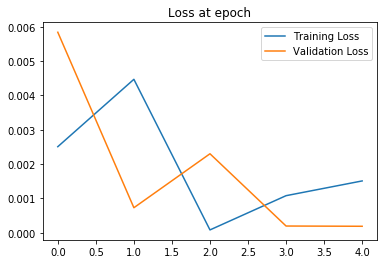

In [27]:
plt.plot(train_loss, label="Training Loss")
plt.plot(test_loss, label="Validation Loss")
plt.title("Loss at epoch")
plt.legend()

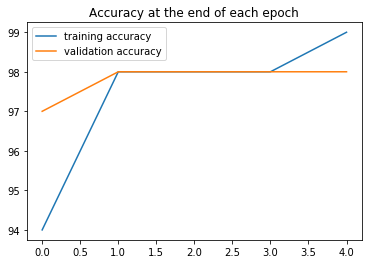

In [28]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [37]:
# Predict on actual demonstration.
test_all_data = DataLoader(test_dataset, batch_size=10_000, shuffle=False)

with torch.no_grad():

    y_correct = 0

    for X_test, y_test in test_all_data:

        y_pred = model.forward(X_test)

        predicted = torch.max(y_pred, dim=1)[1]
        y_correct += (predicted == y_test).sum()

        print(f'{int(y_correct.item() / len(y_pred) * 100):.4f}')

98.0000


In [40]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 976    0    0    0    1    2    5    2    4    2]
 [   1 1130    5    0    0    0    2    3    0    2]
 [   1    2 1019    8    1    0    1    8    4    0]
 [   0    0    0  994    0    8    0    0    0    1]
 [   0    0    2    0  976    0    2    0    1    8]
 [   0    1    0    4    0  872    1    0    0    3]
 [   1    1    0    0    1    5  945    0    1    0]
 [   1    0    5    1    0    1    0 1011    1    4]
 [   0    1    1    3    0    1    2    3  959    4]
 [   0    0    0    0    3    3    0    1    4  985]]


In [59]:
# Feed and predict a single image.
s_img = test_dataset[333][0].reshape(28, -1)
print(s_img)
print(s_img.shape)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

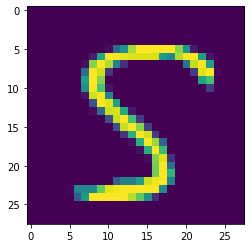

In [60]:
plt.imshow(s_img)

In [61]:
# Predict the value.

model.eval()
with torch.no_grad():

    y_pred = model.forward(s_img.view(1, -1, 28, 28))
    print(y_pred.argmax())


tensor(5)
